# Self-Organizing Maps

The Self-Organizing Map (SOM) was created in the 1980s by Teuvo Kohonen (for this reason, it is sometimes called the Kohonen map). The algorithm falls into the category of unsupervised learning, and is useful primarily for finding patterns in data. Its objective is to represent high-dimensional data in a lower dimensional space, while preserving the data's topology. Usually, the result is two-dimensional or three-dimensional. The reason for this is generally so the results can be visualized in a way that humans can understand.

Although SOMs are often described as performing "dimensionality reduction," this term can be somewhat misleading. In contrast to techniques like Principal Component Analysis (PCA), which directly reduce the number of features in the data, SOMs retain the full dimensionality of the feature space. Instead, they arrange the data into a lower-dimensional structure that makes patterns more apparent.

Under the hood, the algorithm utilizes a randomly-initiated neural network that is assembled into a grid. The size of this grid is a user-defined parameter. Each element in the grid is called a node (or neuron), and each node has a vector of weights associated with it. The size of the weight vector is equal to the dimensionality of the input data.

For example, let's say our dataset consists of 30,000 samples, where each sample has 128 features associated with it. If we choose to assemble a 10x10 grid, then we will have 100 nodes, each with an associated vector of 128 floating point numbers. As mentioned before, these floating point numbers will start out as random. And throughout the course of training, they will be adjusted in a way that represents the dataset in question. The result can be thought of as a 100-point "summary" of our 30,000-point dataset. 

It should be noted here that the terminology associated with SOMs conflict a bit with traditional neural nets. For instance, a "neuron" usually refers to a single computational unit (a single value in a weight vector). In SOMs, however, a neuron refers to an element on the grid, and thus is represented by an entire weight vector.

In order to train, SOMs utilize something called competitive learning. In this class of learning algorithms, neurons fight for the right to "activate". And the way neurons "compete" is through their similarity to a given input. In other words, the more similar a node is to the input data, the more it responds.

There are many ways to score similarity. For this post, we will use euclidean distance, which measures how far apart corresponding elements in two vectors are.

Euclidean
$d(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$

During training, certain neurons will learn to respond to inputs with certain properties. Whether a neuron responds or not is based on how similar it is to the input. The node with the weight vector that is most similar to the input is called the **Best Matching Unit (BMU)**. The weights of the BMU, and its nearst neighbors, are adjusted towards the input vector.

To govern which nodes are nearest to the BMU, we use something called a neighborhood function. This function will score nodes based on their proximity to a radius sorrounding the BMU. The size of the radius decreases with time, so that the weight updates gradually become more and more localized.

Lastly, the magnitude of adjustment also considers a learning rate, which decays over time. 

The update rule can be seen below:

$\mathbf{w}_{i}(t+1) = \mathbf{w}_{i}(t) + \alpha(t) \cdot h_{ci}(t) \cdot (\mathbf{x}(t) - \mathbf{w}_{i}(t))$

where:
- $\mathbf{w}_{i}(t)$ is the weight vector of node i at time t.
- $\alpha(t)$ is the learning rate at time t
- $h_{ci}(t)$ is the proximity of node i, given by the neighborhood function centered around the BMU c
- $\mathbf{x}(t)$ is the input vector at time t.

This update rule ensures that the grid self-organizes to capture the structure of the input data, with similar data points activating nearby nodes, forming clusters that preserve the topology of the original data.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler

sns.set_style("darkgrid")


## Building a Self-Organizing Map

To see how this works, we will build a Self-Organizing Map to capture the patterns in the MNIST dataset. If you're not familiar, MNIST consists of 28x28 images of hand-written digits (0 through 9). The goal is usually to classify these images by trainig a model to predict which digit is present in the image.

However, for our purposes, the goal will be to utitlize a SOM to visualize the underlying relationships in the MNIST dataset.

To do this, I implemented the SOM algorithm using numpy, trained it on MNIST, and visualized the weights of each node in the grid. The code can be found here.

In [46]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def euclidean_distance(a: np.ndarray, b: np.ndarray, axis: int = -1):
    return np.linalg.norm(a - b, axis=axis)


def cosine_distance(a: np.ndarray, b: np.ndarray, axis: int = -1):
    """Computed as: `1 - cosine similarity`
    """
    return 1. - (np.dot(a, b) / (np.linalg.norm(a, axis=axis) * np.linalg.norm(b, axis=axis)))


class MNISTGIFGenerator(object):
    def __init__(self):
        self.images = []

    def append(self, som):
        """Create a subplot grid of the SOM weights and add it as a frame in the GIF."""
        fig, axes = plt.subplots(som.shape[0], som.shape[1], figsize=(som.shape[1], som.shape[0]))
        for i in range(som.shape[0]):
            for j in range(som.shape[1]):
                axes[i, j].imshow(som.w[i, j].reshape(28, 28), cmap='gray')
                axes[i, j].axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)  # Remove spacing between images
        fig.canvas.draw()

        # Convert figure to numpy array and store it
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        self.images.append(image)
        plt.close(fig)  # Close the figure to save memory

    def create(self, fp: str = None):
        fig, ax = plt.subplots()
        ax.axis('off')
        im = ax.imshow(self.images[0], animated=True)

        def _update_image(i):
            im.set_array(self.images[i])
            return [im]

        ani = animation.FuncAnimation(
            fig,
            _update_image,
            frames=len(self.images),
            interval=200,  # milliseconds
            blit=True,
            repeat_delay=5000
        )

        if fp is not None:
            ani.save(fp, writer="pillow")
        plt.show()

class SOM(object):
    """
    Self-Organizing Map

    Params
    --------
    `distance_metric`: str
        activation distance metric
    `d_input`: str
        dimensionality of the input
    `shape`: tuple
        shape of the map
    `alpha`: float
        learning rate
    `iterations`: int
        number of iterations to train.
        It also serves as the decay factor `D` in the formula: `alpha * exp(-step/D)`

    - `Reference`: https://en.wikipedia.org/wiki/Self-organizing_map
    """

    def __init__(self, distance_metric: str, d_input: int, shape: tuple, alpha: float, iterations: int, gif: bool = False):
        self._distance_metrics = {
            "euclidean": euclidean_distance,
            "cosine": cosine_distance
        }
        self.distance_metric = self._distance_metrics[distance_metric]  # key error if metric not found.
        self.d_input = d_input
        self.alpha = alpha
        self.iterations = iterations
        self.shape = shape
        self.w = self._init_weights(shape=self.shape, input_size=self.d_input)
        self.initial_radius = max(self.shape) / 2
        self.C =  self.iterations / np.log(self.initial_radius)
        self.gif = MNISTGIFGenerator() if gif else gif

    def _init_weights(self, shape: tuple, input_size: int):
        """generates initial weights (neurons)"""
        w = np.random.rand(*shape, input_size)
        return w

    def __repr__(self):
        info = {"d_input": self.d_input, "shape": self.shape, "initial_radius": self.initial_radius, "C": self.C}
        return f"SelfOrganizingMap({info})"

    def find_bmu_index(self, x: np.ndarray):
        """find the index of the best matching unit."""
        d = self.distance_metric(self.w, x)
        bmu_idx = np.unravel_index(np.argmin(d), d.shape)
        return bmu_idx

    def update_weights(self, sample, bmu_index, radius, iteration):
        grid_x, grid_y = np.meshgrid(np.arange(self.shape[0]), np.arange(self.shape[1]), indexing='ij')
        # calculate the distance to the BMU
        x_dist = grid_x - bmu_index[0]
        y_dist = grid_y - bmu_index[1]
        # manhatten dist: sum of the absolute differences between the coordinates of the points
        # neighborhood = 1 / (2**(np.abs(x_dist) + np.abs(y_dist))).reshape(self.shape[0], self.shape[1], 1)

        # guassian neighborhood function
        bmu_distance = np.sqrt(x_dist**2 + y_dist**2)
        neighborhood = np.exp(-bmu_distance**2 / (2 * (radius**2))).reshape(self.shape[0], self.shape[1], 1)
    
        # update learning rate and weights
        a = self.alpha * np.exp(-iteration / self.iterations)
        self.w += a * neighborhood * (sample - self.w)

    def train(self, data: np.ndarray):
        size = len(data)
        for i in range(1, self.iterations + 1):
            sample_idx = np.random.randint(0, size)
            sample = data[sample_idx]
            bmu_idx = self.find_bmu_index(sample)
            # radius decreases over every iteration, so updates become more localized.
            radius = self.initial_radius * np.exp(-i / self.C)
            self.update_weights(sample, bmu_idx, radius, i)
            if i % 1000 == 0:
                if self.gif:
                    self.gif.append(self)
                print(f"Iteration {i}/{self.iterations} completed.")


def load_mnist():
    """Load flattened MNIST data with shape(n_sample, 784)"""
    mnist = fetch_openml("mnist_784").data.to_numpy()
    data = mnist.astype(np.float32)
    return data



In [4]:
data = load_mnist()
data.shape

(70000, 784)

In [60]:
scaler = MinMaxScaler()
scaler.fit(data)

model = SOM(distance_metric="euclidean", d_input=784, shape=(15, 15), alpha=0.5, iterations=50_000, gif=True)
print(model)
model.train(scaler.transform(data))


SelfOrganizingMap({'d_input': 784, 'shape': (15, 15), 'initial_radius': 7.5, 'C': np.float64(24815.0901012316)})
Iteration 1000/50000 completed.
Iteration 2000/50000 completed.
Iteration 3000/50000 completed.
Iteration 4000/50000 completed.
Iteration 5000/50000 completed.
Iteration 6000/50000 completed.
Iteration 7000/50000 completed.
Iteration 8000/50000 completed.
Iteration 9000/50000 completed.
Iteration 10000/50000 completed.
Iteration 11000/50000 completed.
Iteration 12000/50000 completed.
Iteration 13000/50000 completed.
Iteration 14000/50000 completed.
Iteration 15000/50000 completed.
Iteration 16000/50000 completed.
Iteration 17000/50000 completed.
Iteration 18000/50000 completed.
Iteration 19000/50000 completed.
Iteration 20000/50000 completed.
Iteration 21000/50000 completed.
Iteration 22000/50000 completed.
Iteration 23000/50000 completed.
Iteration 24000/50000 completed.
Iteration 25000/50000 completed.
Iteration 26000/50000 completed.
Iteration 27000/50000 completed.
Itera

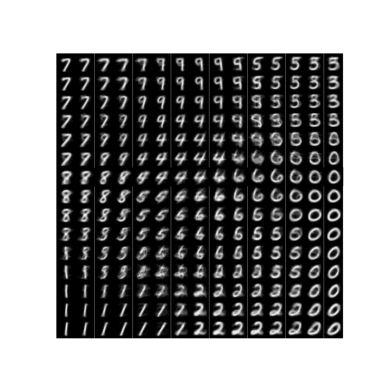

In [61]:
model.gif.create(fp="training.gif")


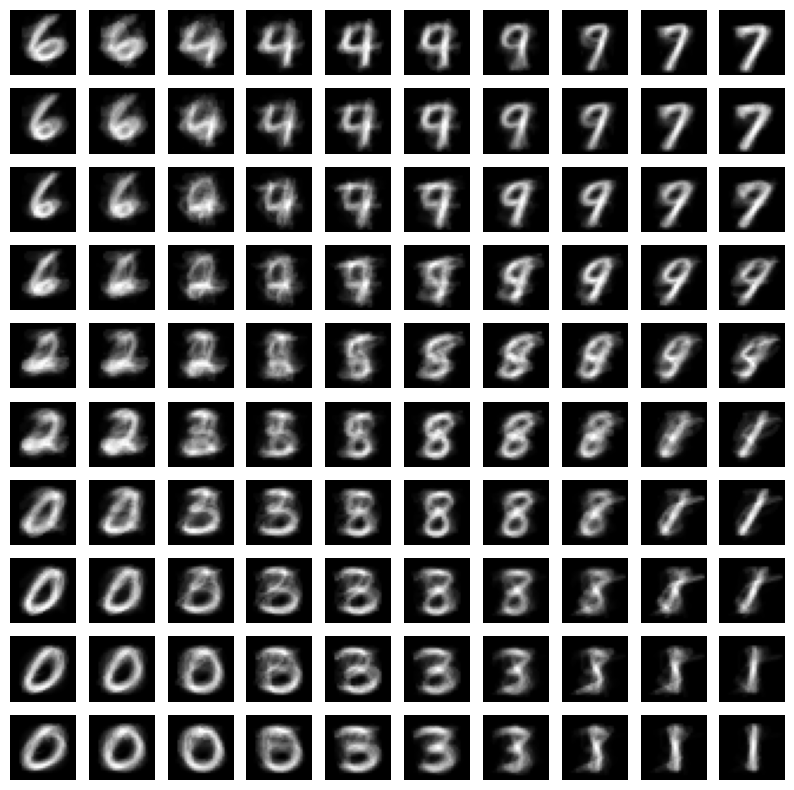

In [59]:
def visualize_som_mnist(som, fp: str = None):
    fig, axes = plt.subplots(som.shape[0], som.shape[1], figsize=som.shape)
    weights = som.w

    for i in range(som.shape[0]):
        for j in range(som.shape[1]):
            # MNIST images are 28x28
            axes[i, j].imshow(weights[i, j].reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')

    if fp is not None:
        plt.savefig(fp, bbox_inches="tight")
    plt.show()

visualize_som_mnist(model, fp="15x15_50k.png")
